In [1]:
from IMP_CW_env import MESCEnv
import numpy as np 
from scipy.optimize import minimize, basinhopping

from HeuristicPolicy_file import HeuristicPolicy, Optimizer
from utils import plot_reward_distribution

import matplotlib.pyplot as plt
%matplotlib inline

# **Training environment definition**

In [2]:
n_retailers = 2
n_DCs = 1
n_suppliers = 1
supply_chain_structure = [[n_retailers] , [n_DCs], n_suppliers]

# **Policy optimization**
### Instantiate objects

In [3]:
env_train = MESCEnv(supply_chain_structure)
sSpolicy = HeuristicPolicy()

### **Run optimization**

In [4]:
from scipy.optimize import Bounds
bounds = Bounds(np.zeros(6), [env_train.retailers[0].order_quantity_limit, # bounds for s_r1
                              env_train.retailers[0].order_quantity_limit, # bounds for S_r1
                              env_train.retailers[1].order_quantity_limit, # bounds for s_r2
                              env_train.retailers[1].order_quantity_limit, # bounds for S_r2
                              env_train.DCs[0].order_quantity_limit, # bounds for s_DC
                              env_train.DCs[0].order_quantity_limit]) # bounds for S_DC

In [5]:
optimizer = Optimizer(sSpolicy.objective_fcn, env_train)
options = None
results = sSpolicy.optimize_policy(env_train, optimizer.calculate_reward, method = 'Powell', bounds=bounds, callback = optimizer.callback, options = options)

Get solution

In [6]:
optimizer.get_best_solution()
optimal_policy_sS = np.clip(np.floor(optimizer.best_x),a_min=0.,a_max=None).astype(int)

In [7]:
print(f'Converged: {results.success}')
print(f'Number of iterations: {optimizer.iter} \nBest objective function value: {optimizer.best_f:.2f}\nMaximum reward: {-1*optimizer.best_f:.2f}\nOptimal (s,S) policy: {optimal_policy_sS}')

Converged: True
Number of iterations: 3 
Best objective function value: -235942.00
Maximum reward: 235942.00
Optimal (s,S) policy: [ 19  34  17  25  79 138]


Visualize reward evolution

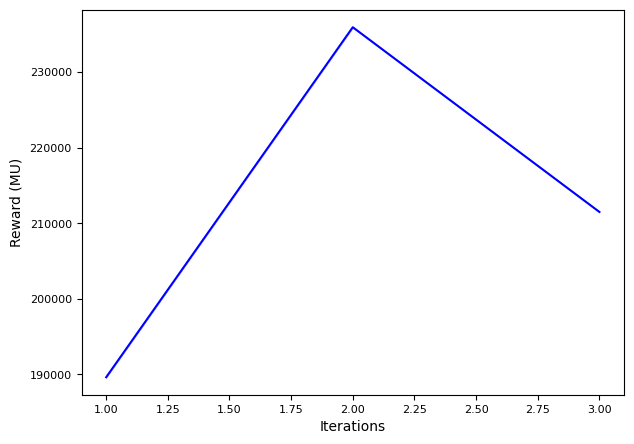

In [8]:
optimizer.plot_learning_curve()

# **(s,S) Policy evaluation**

Note that here the policy is tested in the same environment where it was trained.

### Test dataset of demands
It will contain 100 samples for testing, each with 52 weeks.

In [9]:
test_demand_dataset = []
env_train.seed = 42
for _ in range(0,100):
    demands_episode, _ = env_train.sample_demands_episode()
    test_demand_dataset.append(demands_episode)

### Policy evaluation
Set the optimal policy parameters before running the evaluation.

In [10]:
sSpolicy.policy_param = optimal_policy_sS

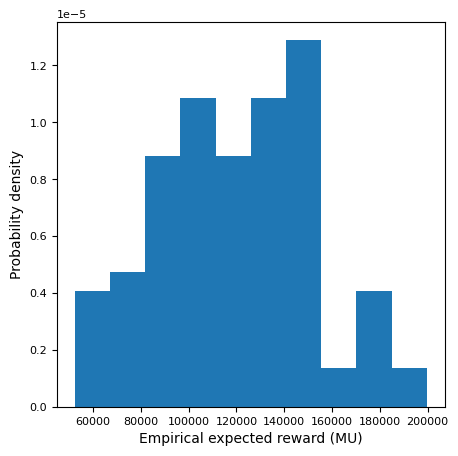

In [11]:
reward_list = sSpolicy.evaluate_policy(env_train, test_demand_dataset)
plot_reward_distribution(reward_list)